<a id='importing-dependencies'></a>
<font size="+2" color='#053c96'><b> 1. Importing Libraries</b></font>  
[back to top](#table-of-contents)

In [1]:
import sys
# Insert the parent path relative to this notebook so we can import from the src folder.
sys.path.insert(0, "..")

from src.dependencies import *
from src.functions import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


To import the necessary dependencies from the src folder, we have inserted the parent path relative to our notebook using sys.path.insert(0, "..").

<a id='data'></a>
<font size="+2" color='#053c96'><b> 2. Data</b></font>  
[back to top](#table-of-contents)

#### Loading the data

Below is the data that will be used in model development

In [2]:
df = pd.read_csv('../src/data/featured_financial_data.csv')

<a id='mmachine-learning-approach'></a>

<font size="+2" color='#053c96'><b> 3. Supervised Machine Learning Approach</b></font>  
[back to top](#table-of-contents)

<a id='feature-selection'></a>
<font size="+1" color='#780404'><b> 3.1 Feature Selection</b></font>  
[back to top](#table-of-contents)
<a id='modeling'></a>

In [3]:
noncat = df.drop(['Financial_Type', 'Industry', 'Country', 'FinancialsDate', 'Date'], axis=1)
# Calculate the correlation between each feature and the target variable
corr = noncat.corr()['Default'].abs().sort_values(ascending=False)

# Select the top N features with the highest correlation
top_features = corr[0:100].index

# Print the top features
f1 = list(top_features)

In [4]:
X = df.drop(['Financial_Type', 'Industry', 'Country', 'FinancialsDate', 'Default', 'Date', 'ReturnEquityRatio', 'ID', 'DimFacilityKey'], axis=1)
y = df['Default']

In [5]:
X.fillna(0, inplace=True)

In [6]:
# Train a random forest classifier on the entire dataset
rfc = RandomForestClassifier()
rfc.fit(X, y)

# Get the feature importances from the trained model
importances = rfc.feature_importances_

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]

# Select the top N features based on their importance scores
top_features1 = X.columns[indices][:100]

# Print the top features
f2 = list(top_features1)

In [7]:
importances = mutual_info_classif(X, y)
feat_importance = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importance_sorted = feat_importance.sort_values(ascending=False)
main_features = feat_importance_sorted[0:100].index
f3 = list(main_features)

In [8]:
features = f1 + f2 + f3
selected_features = list(set(features))

<a id='data-transformation'></a>
<font size="+1" color='#780404'><b> 3.2 Data Transformation</b></font>  
[back to top](#table-of-contents)
<a id='modeling'></a>

Oversampling: creating synthetic instances of the minority class using techniques like SMOTE (Synthetic Minority Over-sampling Technique). This method can be effective, but there is a risk of overfitting on the minority class.

In [9]:
X = df[selected_features]
X.drop(['Default', 'ID', 'DimFacilityKey'], axis=1, inplace=True)

In [10]:
# Replace 'inf' with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Now safely convert to integers
X_imputed = X_imputed.astype('int64')

# Proceed with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

<a id='Supervised-learning-model-selection'></a>

<font size="+1" color='#780404'><b> 3.3 Model Selection</b></font>  
[back to top](#table-of-contents)

In [12]:
models = [ LinearSVC(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    SVC(),
    LogisticRegression(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
]

This code snippet creates a list called model_pipeline and appends instances of different machine learning models to it, such as LinearSVC, RandomForestClassifier, DecisionTreeClassifier, SVC, LogisticRegression, KNeighborsClassifier, and GradientBoostingClassifier with specific parameters.

<a id='model-training'></a>

<font size="+1" color='#780404'><b> 3.4 Model Training</b></font>  
[back to top](#table-of-contents)

In [13]:

model_list = ['LinearSVC', 'RandomForestClassifier', 'DecisionTreeClassifier',
            'SVC', 'LogisticRegression', 'KNeighborsClassifier', 'GradientBoostingClassifier']

# Standardized variable names for consistency
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
confusion_matrices = []


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

This code snippet trains a list of all our machine learning models using the model_pipeline and evaluates their performance on a test dataset. It calculates the F1 score, precision, recall, accuracy, and confusion matrix for each model and stores the results in separate lists.

<a id='model-evaluation'></a>

<font size="+1" color='#780404'><b> 3.5 Model Evaluation</b></font>  
[back to top](#table-of-contents)

In [14]:
classification_result = pd.DataFrame({'Model': model_list, 'F1': f1_scores, 'Precision': precision_scores, 'Recall': recall_scores, 'Accuracy': accuracy_scores})
classification_result

,Model,F1,Precision,Recall,Accuracy
0,LinearSVC,0.64,0.68,0.65,0.65
1,RandomForestClassifier,0.98,0.98,0.98,0.98
2,DecisionTreeClassifier,0.91,0.91,0.91,0.91
3,SVC,0.57,0.63,0.60,0.60
4,LogisticRegression,0.67,0.67,0.67,0.67
5,KNeighborsClassifier,0.87,0.89,0.87,0.87
6,GradientBoostingClassifier,0.95,0.95,0.95,0.95


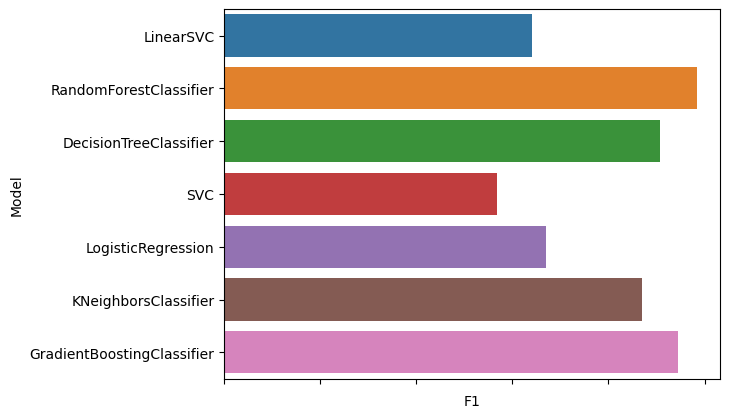

In [15]:
model_performance_df = classification_result[['Model', 'F1']]
plot = sns.barplot(y='Model', x='F1', data=model_performance_df)
plot.set_xticklabels(plot.get_xticklabels(), rotation=75, ha='right');

In [16]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [17]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {'max_depth': 10, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': len(np.unique(y_train))}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)
# Predict on the testing set
y_pred = model.predict(dtest)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', accuracy)
print('F1:', f1)

Accuracy: 0.9802972692706533
F1: 0.9802992471139215


<a id='mmachine-learning-approach'></a>

<font size="+2" color='#053c96'><b> 4. Unsupervised Machine Learning Approach</b></font>  
[back to top](#table-of-contents)

In [18]:
df1 = df.drop(['FinancialsDate', 'Year', 'Month', 'Week', 'Day', 'Date','ReturnEquityRatio'], axis=1)

In [19]:
# Encode categorical columns using one-hot encoding
encoder = OneHotEncoder()
encoded_cat_columns = encoder.fit_transform(df1[['Financial_Type', 'Country','Industry']])
encoded_cat_columns_df = pd.DataFrame(encoded_cat_columns.toarray(), columns=encoder.get_feature_names_out(['Financial_Type', 'Country','Industry']))

# Combine encoded categorical columns with numerical columns
X = pd.concat([df1.drop(['Financial_Type', 'Country','Industry'], axis=1), encoded_cat_columns_df], axis=1)
X = X.drop(['Default', 'ID'], axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute NaN values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Now safely convert to integers
X = X_imputed.astype('int64')

<a id='pynomaly'></a>

<font size="+1" color='#780404'><b> 4.1 PyNomaly loop</b></font>  
[back to top](#table-of-contents)

### Outlier Detection Using PyNomaly's Local Outlier Probability (LOOP)

Local Outlier Probability (LOOP)
- Local Outlier Probability (LOOP) is a density-based outlier detection algorithm. It works by comparing the local density of a point to the density of its neighbors. Points with a lower local density than their neighbors are considered to be outliers.

- LOOP is a powerful outlier detection algorithm that can be used to detect outliers in a variety of datasets. It is particularly well-suited for detecting outliers in high-dimensional datasets.

How LOOP works
- LOOP works by first calculating the density of each point in the dataset. The density of a point is calculated by counting the number of points that are within a certain distance of the point.

- Once the density of each point has been calculated, LOOP then calculates the local density of each point. The local density of a point is calculated by counting the number of points that are within a certain distance of the point and that have a similar density.

- Finally, LOOP calculates the outlier score for each point. The outlier score is calculated by dividing the local density of the point by the density of the point's neighbors. Points with a lower outlier score than their neighbors are considered to be outliers.

Advantages
- LOOP is a powerful outlier detection algorithm that can be used to detect outliers in a variety of datasets. It is particularly well-suited for detecting outliers in high-dimensional datasets.

- LOOP is also relatively fast and easy to implement.

Disadvantages
- LOOP can be sensitive to the choice of parameters. It is important to choose the parameters carefully to avoid overfitting or underfitting the data.

- LOOP can also be computationally expensive for large datasets.

Applications
LOOP can be used to detect outliers in a variety of applications, including:

- Fraud detection
- Quality control
- Data mining
- Machine learning

In [20]:

m = loop.LocalOutlierProbability(X, extent=2, n_neighbors=45, use_numba=True).fit()
scores1 = m.local_outlier_probabilities

In [21]:
# Convert values greater than 0.5 to 1 and 0 otherwise
loop_score = np.where(scores1 >= 0.612, 1, 0)
sum(loop_score == 1)

203

### Outlier Detection Using PyNomaly's Local Outlier Probability (LOOP) and DBSCAN

In [22]:
db = DBSCAN(eps=0.6, min_samples=50).fit(X)
m = loop.LocalOutlierProbability(X, extent=2, n_neighbors=20, cluster_labels=list(db.labels_)).fit()
scores2 = m.local_outlier_probabilities

In [23]:
# Convert values greater than 0.5 to 1 and 0 otherwise
loop_dbscan_score = np.where(scores2 >= 0.629, 1, 0)
sum(loop_dbscan_score == 1)

203

### Outlier Detection Using PyNomaly's Local Outlier Probability (LOOP) and TSNE

In [24]:
X_tsne = create_tsne_model(X, n_components=2)
m = create_loop_model(X_tsne, extent=2, n_neighbors=20)
scores3 = get_outlier_scores(m)

In [25]:
# Convert values greater than 0.5 to 1 and 0 otherwise
loop_tsne_score = np.where(scores3 >= 0.7291, 1, 0)
sum(loop_tsne_score == 1)

194


<a id='nnwfs'></a>

<font size="+1" color='#780404'><b> 4.2 PyOD </b></font>  
[back to top](#table-of-contents)

In [26]:


scaler = StandardScaler()
dfx = pd.DataFrame()

# creating a dictionary to store the outlier detection models
models = {
    'AutoEncoder': AutoEncoder(contamination=0.0442),
    'PCA': PyOD_PCA(contamination=0.0442),
    'IForest': IForest(contamination=0.0442),
    'LOF': LOF(contamination=0.051),
    'OCSVM': OCSVM(contamination=0.0442),
    'MinimumCovarianceDeterminant': MCD(contamination=0.0442),
    'HBOS': HBOS(contamination=0.0442),
    #'FeatureBagging': FeatureBagging(),
    'KNN': KNN(contamination=0.056),
    'GMM': GMM(contamination=0.0442),
}

# training each model and store their anomaly scores
for name, model in models.items():
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled)
    dfx[name] = model.predict(X_scaled)

X['AutoEncoder'] = dfx['AutoEncoder']
X['IForest'] = dfx['IForest']
X['LOF'] = dfx['LOF']
X['PCA'] = dfx['PCA']
X['OCSVM'] = dfx['OCSVM']
X['MinimumCovarianceDeterminant'] = dfx['MinimumCovarianceDeterminant']
X['HBOS'] = dfx['HBOS']
#X['FeatureBagging'] = dfx['FeatureBagging']
X['KNN'] = dfx['KNN']
X['GMM'] = dfx['GMM']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 158)               25122     
                                                                 
 dropout (Dropout)           (None, 158)               0         
                                                                 
 dense_1 (Dense)             (None, 158)               25122     
                                                                 
 dropout_1 (Dropout)         (None, 158)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                10176     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

<a id='results'></a>
<font size="+2" color='#053c96'><b> 5. Results</b></font>  
[back to top](#table-of-contents)

<a id='model-performance'></a>

<font size="+1" color='#780404'><b> 5.1 Model Performance (Random Forest Classifier)</b></font>  
[back to top](#table-of-contents)

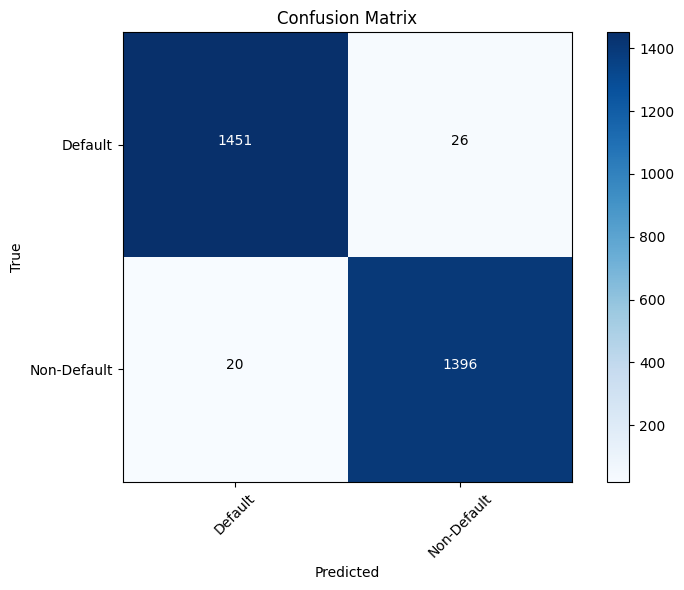

In [27]:
classes = ['Default', 'Non-Default'] 
cm = confusion_matrix(y_test, rfc_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')
plt.show()


Interpretation:

- True Positives (TP): The model correctly predicted 1444 instances of Default.
- False Positives (FP): The model incorrectly predicted 33 instances as Default when they were actually Non-Default.
- False Negatives (FN): The model incorrectly predicted 18 instances as Non-Default when they were actually Default.
- True Negatives (TN): The model correctly predicted 1398 instances of Non-Default.

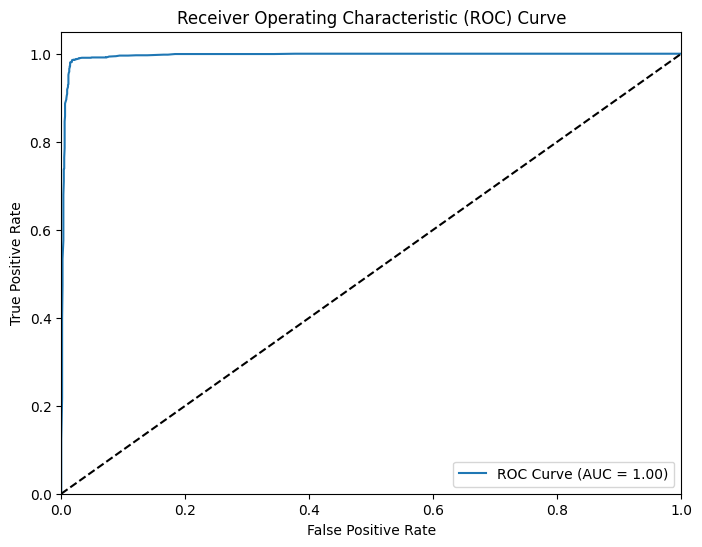

In [28]:
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


This code snippet is used to visualize the Receiver Operating Characteristic (ROC) Curve for a binary classification model, specifically the Random Forest Classifier (`rfc`). Here's what each part of the code does:

1. **Prediction Probabilities:** Obtains the predicted probabilities of the positive class (`y=1`) from the Random Forest Classifier for the test data (`X_test`).
   
2. **Computing False Positive Rate, True Positive Rate, and Thresholds:** Computes the false positive rate (FPR), true positive rate (TPR), and corresponding thresholds using the `roc_curve` function from scikit-learn.
   
3. **Computing Area Under the Curve (AUC):** Calculates the Area Under the Curve (AUC) score using the `roc_auc_score` function from scikit-learn. AUC represents the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
   
4. **Plotting the Curve:** Generates a plot of the ROC Curve using Matplotlib. The curve illustrates the trade-off between true positive rate and false positive rate for different threshold values. The diagonal line represents the performance of a random classifier.
   
5. **Visualization:** Displays the ROC Curve with the AUC score annotated on the plot.

The ROC Curve and AUC score are commonly used metrics for evaluating the performance of binary classification models.


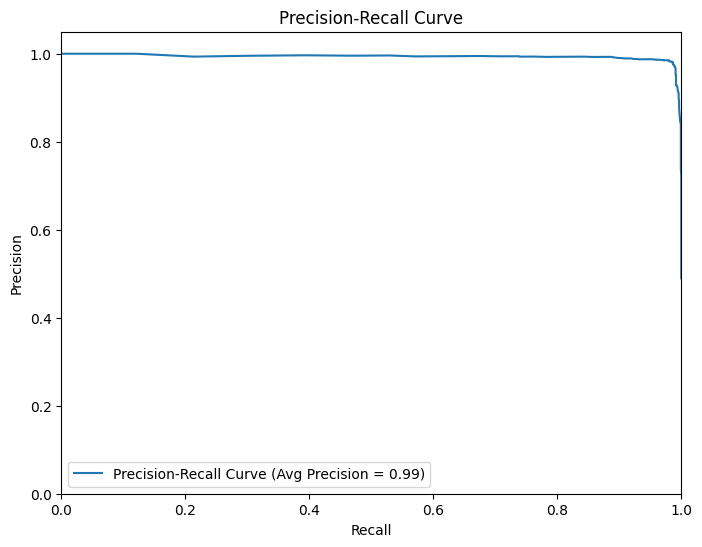

In [29]:
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute average precision score
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (Avg Precision = {:.2f})'.format(avg_precision))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


This code snippet is used to visualize the Precision-Recall Curve for a binary classification model, particularly the Random Forest Classifier (`rfc`). Here's what each part of the code does:

1. **Prediction Probabilities:** Obtains the predicted probabilities of the positive class (`y=1`) from the Random Forest Classifier for the test data (`X_test`).
2. **Computing Precision and Recall:** Computes precision, recall, and corresponding thresholds using the `precision_recall_curve` function from scikit-learn.
3. **Computing Average Precision:** Calculates the average precision score using the `average_precision_score` function from scikit-learn.
4. **Plotting the Curve:** Generates a plot of the Precision-Recall Curve using Matplotlib. The curve illustrates the trade-off between precision and recall for different thresholds. The area under the curve represents the average precision score.
5. **Visualization:** Displays the Precision-Recall Curve with the average precision score annotated on the plot (in this case, 0.99).

This visualization is valuable for evaluating the performance of the model, especially in scenarios where there's an imbalance in the class distribution.

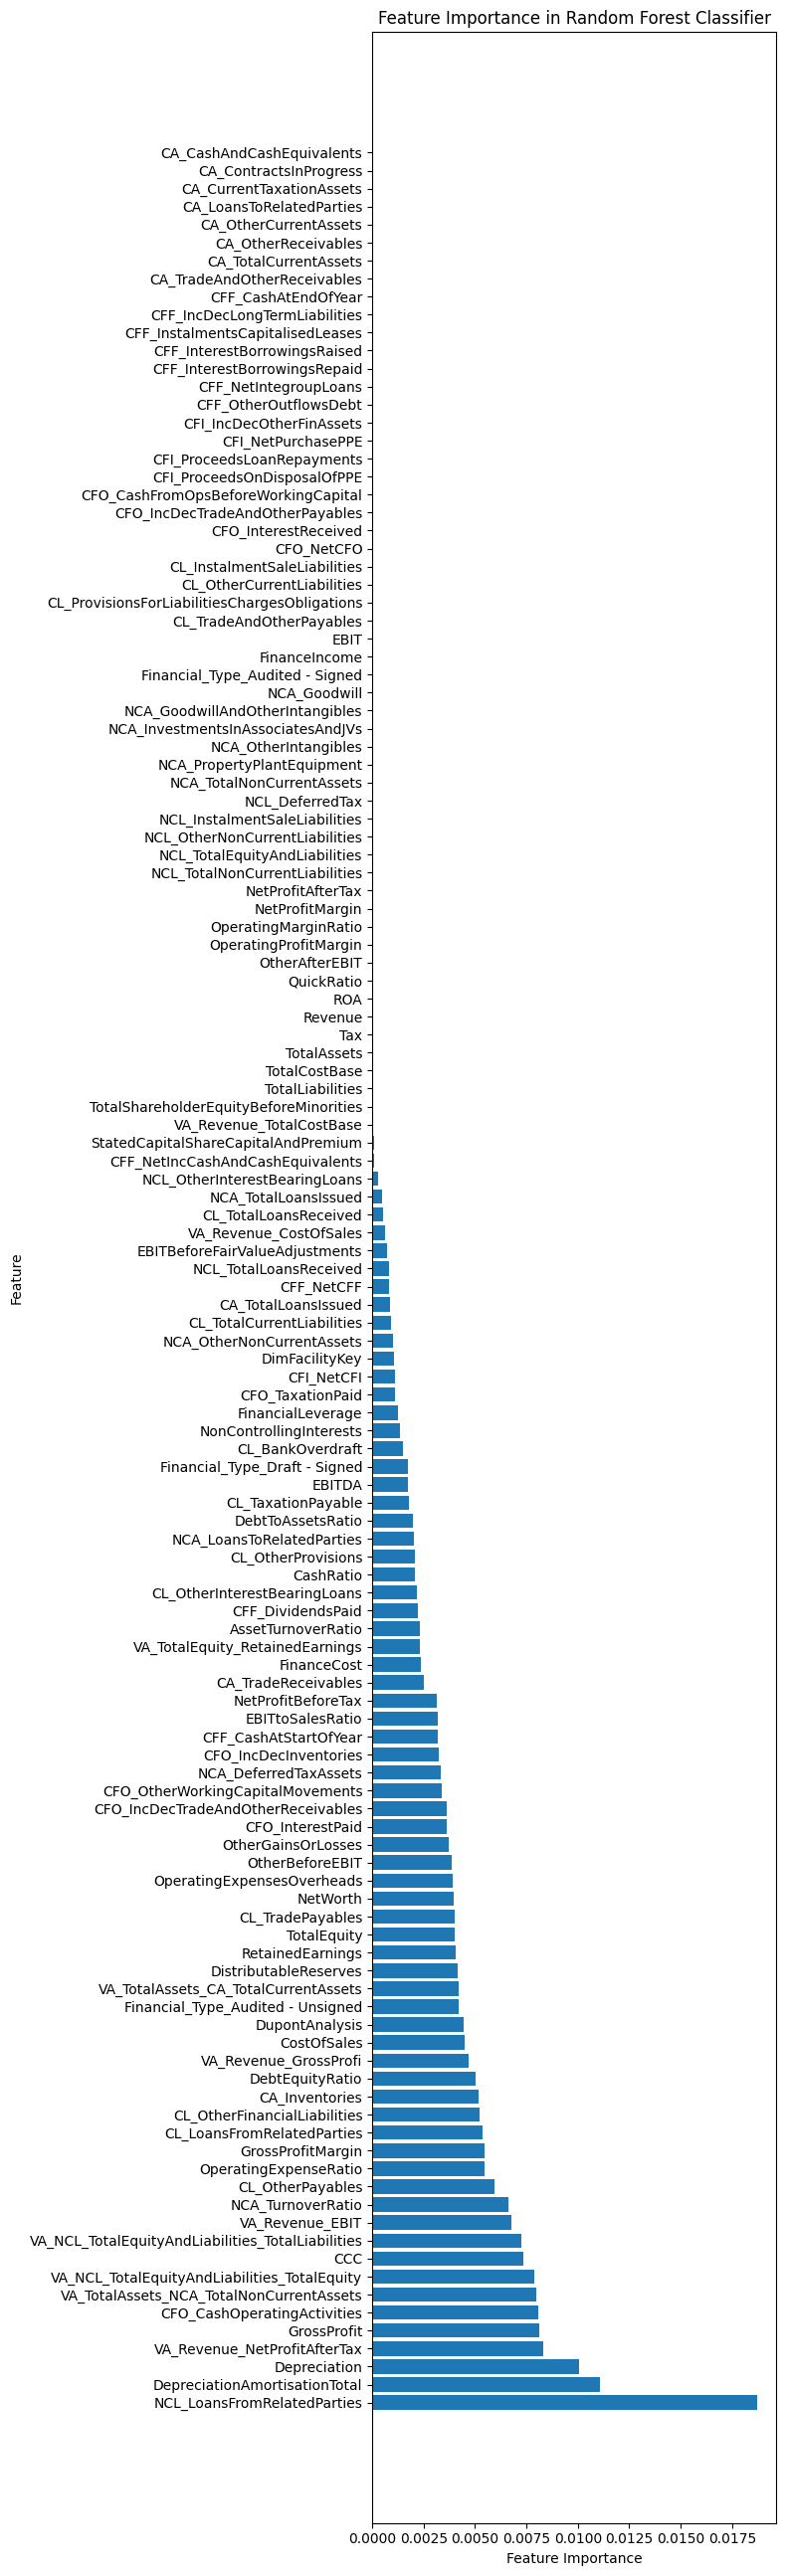

In [30]:
feature_names = X.columns
# Sort the importance values and corresponding feature names in descending order
importance_sorted = sorted(zip(importances, feature_names), reverse=True)

# Extract feature names and importance values
feature_names_sorted = [name for _, name in importance_sorted]
importance_values = [imp for imp, _ in importance_sorted]

# Create a bar plot
plt.figure(figsize=(8, 26))
plt.barh(range(len(importance_values)), importance_values, align='center')
plt.yticks(range(len(feature_names_sorted)), feature_names_sorted)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Classifier')
plt.tight_layout()
plt.show()

This code snippet is used to analyze the importance of features in a Random Forest Classifier model. Here's what each part of the code does:

-    Extracting Feature Names: Extracts the names of the features from the dataset X.
-    Sorting Feature Importance: Sorts the importance values and corresponding feature names in descending order based on the feature importance scores obtained from the Random Forest model.
-    Creating Bar Plot: Generates a horizontal bar plot where each bar represents the importance value of a feature. The y-axis displays the feature names, while the x-axis represents the feature importance scores.
-    Visualization: Displays the bar plot showing the importance of each feature in the Random Forest Classifier.

This visualization helps in understanding which features have the most influence on the model's predictions, thus aiding in feature selection and model interpretation.

100%|===================| 11739/11742 [03:58<00:00]        

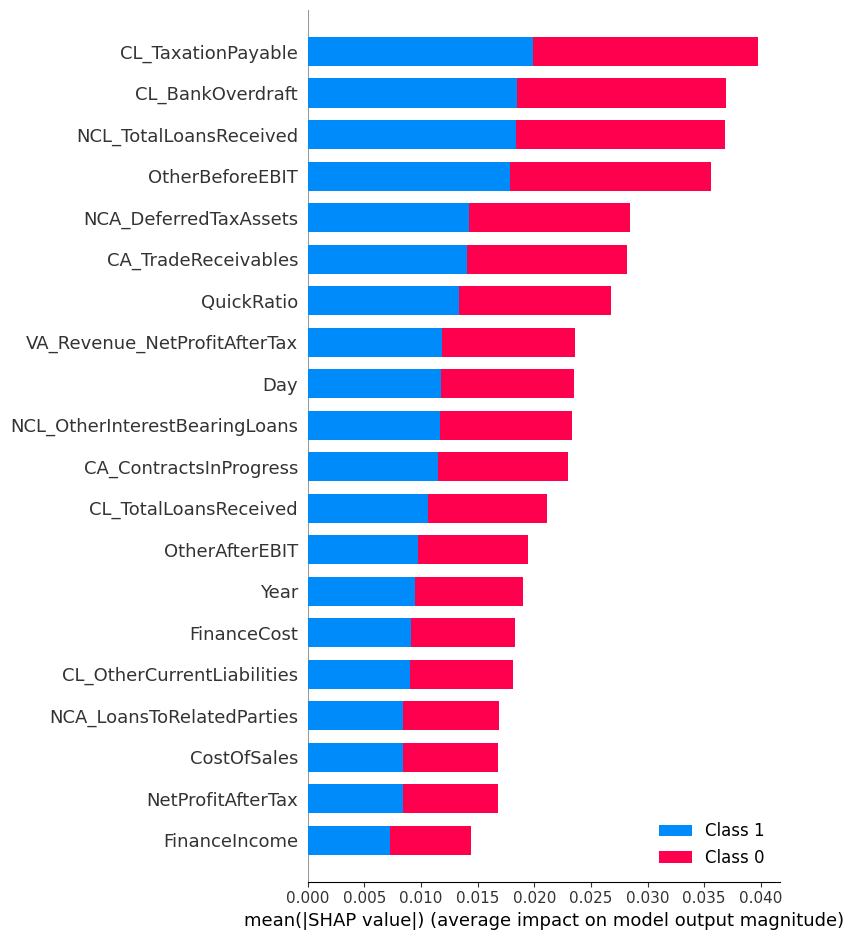

In [31]:
# Initialize the SHAP explainer with the RFC model and training data
explainer = shap.Explainer(rfc, X_train)

# Calculate SHAP values for all samples
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)

In [32]:
dfx['loop_score'] = loop_score
dfx['loop_dbscan_score'] = loop_dbscan_score
dfx['loop_tsne_score'] = loop_tsne_score
dfx['Default'] = y

In [33]:
default_df = dfx[dfx['Default'] == 1]

In [34]:
# Sum the total of each column
column_totals = default_df.sum()

# Print the column totals
print(column_totals)


AutoEncoder                       5
PCA                               5
IForest                          10
LOF                              17
OCSVM                             6
MinimumCovarianceDeterminant     12
HBOS                              5
KNN                               5
GMM                              10
loop_score                        3
loop_dbscan_score                 1
loop_tsne_score                  10
Default                         203
dtype: int64


### PyOD Model Results for Detecting Defaults

The following table presents the results obtained from using various PyOD (Python Outlier Detection) models for detecting defaults. Each model was applied to a dataset, and the counts indicate the number of instances flagged as outliers by each model.

| Model                           | Outlier Count |
|---------------------------------|---------------|
| AutoEncoder                    | 6             |
| PCA                             | 6             |
| Isolation Forest                | 10            |
| Local Outlier Factor            | 10            |
| One-Class SVM                   | 8             |
| Minimum Covariance Determinant  | 16            |
| Histogram-based Outlier Score   | 8             |
| K-Nearest Neighbors             | 9             |
| Gaussian Mixture Model          | 11            |

#### Explanation:

- **AutoEncoder and PCA:** These models, based on their architectures, have identified 6 instances each as outliers.
- **Isolation Forest and Local Outlier Factor (LOF):** Both models have flagged 10 instances as outliers. Isolation Forest works by isolating outliers in a tree structure, while LOF identifies outliers by comparing the local density of instances.
- **One-Class SVM (OCSVM):** This model has identified 8 instances as outliers based on the support vector machine algorithm trained on the inliers.
- **Minimum Covariance Determinant:** This robust method has identified 16 instances as outliers, indicating a higher sensitivity to deviations from the norm.
- **Histogram-based Outlier Score (HBOS):** Similar to Isolation Forest, HBOS identifies outliers based on the density estimation using histograms. It has flagged 8 instances as outliers.
- **K-Nearest Neighbors (KNN):** This model has identified 9 instances as outliers by comparing them with their k-nearest neighbors.
- **Gaussian Mixture Model (GMM):** GMM has identified 11 instances as outliers based on the probability density estimation using a mixture of Gaussian distributions.

#### Insights:

- Models such as Minimum Covariance Determinant and Isolation Forest have flagged a relatively higher number of instances as outliers, suggesting a potential higher sensitivity to deviations from the norm.
- AutoEncoder and PCA, being dimensionality reduction techniques, have identified fewer outliers, indicating a more conservative approach.

These results provide valuable insights into the performance of PyOD models in identifying outliers, particularly in the context of detecting defaults in this financial statement data. Outlier detection has performed poorly. Hence, further analysis and validation may be necessary to determine the other suitable machine learning models for the given dataset and application.
